# <center>Block 2: Linear programming: The min-cost flow problem</center>
### <center>Alfred Galichon (NYU)</center>
## <center>`math+econ+code' masterclass on matching models, optimal transport and applications</center>
<center>© 2018-2019 by Alfred Galichon. Support from NSF grant DMS-1716489 is acknowledged. Pauline Corblet, James Nesbit, and Lucas Vernet contributed.</center>

### Learning Objectives 

* Basic concepts of directed networks

* The min-cost flow problem

* Duality, optimality and equilibrium

### References

* [OTME], Ch.8

* Tolstoi (1930). Methods of finding the minimal total kilometrage in cargo transportation planning in space. *Transportation Planning* [in Russian]

* Koopmans (1949). Optimum utilization of the transportation system. *Econometrica*.

* Schrijver (2002). On the History of the Transportation and Maximum Flow Problems. *Mathematical programming*.

## Motivation

### Motivation: network flow problems

In 1930 Tolstoi, a Russian engineer, has to optimize the shipping of cement from factories to cities in the Soviet union through railway.

* each factory produces a fixed number of tons

* each city needs a fixed number of tons -- for now, we'll assume total production=total consumption

* each factory is connected by rail with a few cities, and the corresponding distance is given

* how to ship in order to minimize the total distance travelled?

This problem belongs to the class of *min-cost flow problems*, an important class of linear programming problems, which are the focus of today's lecture. A decade before the invention of linear programming and the work of Kantorovich, Koopmans and Dantzig, Tolstoi described a heuristic method for solving the problem, which led to the optimal solution. We'll solve the problem using modern tools (Gurobi), and will see that his solution was right.

The *shortest path problem*, or how to find the path of minimal distance from a point to another in a network, also belongs in this class. 

In [39]:
# Lets load up libraries now
library('gurobi')
library('Matrix')

## Data

We will be looking at 3 types of data:

### Sovet Planning Problem

Tolstoi's data, collected by Schrijver (2002). There are 10 factories and 68 Soviet cities, and 155 links connecting a factory to a city. This yields a sparse $68\times10$ matrix. Two vectors listing the demand of each city and the supply of each factory are also specified. This is stored in a $69\times11$ matrix, where we have appended the demand/supply vectors to the right and to the botton of the distance matrix.

In [40]:
thePath = paste0(getwd(),"/../data_mec_optim/networks_sovietplanning")
spp_data = as.matrix(read.csv(paste0(thePath, "/distances.csv"), sep = ",", header = TRUE))  # loads the data
head(spp_data)

X,Arkhangelsk,Yaroslavl.,Murom,Balakhonikha,Dzerzhinsk,Kishert.,Sverdlovsk,Artemovsk,Iledzhk,Dekonskaya,demand.
Agryz,NA,NA,NA,709,1064,693,NA,NA,NA,NA,2.0
Aleksandrov,NA,NA,NA,NA,397,NA,NA,1180,NA,NA,4.0
Almaznaya,NA,NA,NA,NA,NA,NA,NA,81,NA,65,1.5
Alchevskaya,NA,NA,NA,NA,NA,NA,NA,106,NA,114,4.0
Baku,NA,NA,NA,NA,NA,NA,NA,1554,NA,1563,10.0
Barybino,NA,NA,NA,NA,NA,NA,NA,985,NA,968,2.0


### Subway

Paris (NYC) subway network data: the network data are available on www.ratp.fr/opendata (http://www.mta.info). This data is made of two files. The file `nodes.csv` lists the stations: each station is indexed by the line number; each line has the name of the station, and its spatial coordinates. The file `arcs.csv` lists the links between stations: each link specifies the index of the origin, the index of the destination, and the length of the segment. 

In [41]:
city = "Paris"
head = FALSE
sep = ","
# city = 'NYC'
#if (city == "Paris") {
#    sep = ";"
#    head = FALSE
#} else {
#    sep = ","
#    head = TRUE
#}


thePath = paste0(getwd() ,"/../data_mec_optim/networks_subway")

sub_arcs = as.matrix(read.csv(paste0(thePath, "/", city, "/arcs.csv"), sep = sep, 
    header = head))  # loads the arc data
sub_nodes = as.matrix(read.csv(paste0(thePath, "/", city, "/nodes.csv"), sep = sep, 
    header = head))  # loads the nodes data
head(sub_arcs) # the colums are origin node index, destination node index and distance
head(sub_nodes) # name, 

V1,V2,V3
1,2,1027.280873
1,319,9.062544
2,1,1027.280873
2,3,785.939117
3,2,785.939117
3,4,1010.642024


V1,V2,V3,V4,V5,V6
La Défense (Grande Arche),14367265,2.237883,48.89193,535,1282
Esplanade de la Défense,9992248,2.250442,48.88784,603,1373
Pont de Neuilly,6823045,2.259892,48.88451,687,1456
Les Sablons (Jardin d'acclimatation),5500065,2.272539,48.88090,767,1539
Porte Maillot,9089205,2.281836,48.87796,863,1633
Argentine,2947071,2.289322,48.87553,998,1766


In [42]:
dim(sub_arcs)
dim(sub_nodes)

[1] 866   3

[1] 366   6

### NYC Roads

The NYC roads data is available,is available as a `shapefile`. The dataset is very similar in construction to the subway data-except that the network is much larger, as there are $67,316$ nodes and $169,399$ arcs. We won't load up this dataset yet, as it is quite large.

## Shortest path problems

### Topology of Networks

We start by defining the directed graph on which transportation takes place.

---
**Definition**

A (directed) *graph* $\left(\mathcal{X},\mathcal{A}\right)$ is a set of *nodes* (cities) $\mathcal{X}$, along with a set of *arcs* $\mathcal{A}\subseteq\mathcal{X}^{2}$ which are pairs $\left(x,y\right)$ where $x,y\in\mathcal{X}$.

---
Our definition allows an arc to have the same origin and destination. Note that for a dense network, $\mathcal{A}=\mathcal{X}^{2}$. For a line, $\left\vert \mathcal{A}\right\vert =\left\vert \mathcal{X}\right\vert -1$.

Next, we define the gradient matrix.

---
**Definition**
<a name="grad_mat"></a>

We define the *gradient matrix* (also called an `edge-node matrix') as the matrix with general term $\nabla_{ax}$, $a\in\mathcal{A}$, $x\in \mathcal{X}$, such that

\begin{align*}
\nabla_{ax}  &  =-1\text{ if }a\text{ is out of }x\text{,}\\
&  =+1\text{ if }a\text{ is into }x\text{,}\\
&  =0\text{ else.}
\end{align*}

---

Hence, if $f\in\mathbb{R}^{\mathcal{X}}$, then $\nabla f\in\mathbb{R}^{\mathcal{V}}$, and $\left(  \nabla f\right)  _{xy}=f_{y}-f_{x}$.

We shall denote $\nabla^{\intercal}$ the transpose of the gradient matrix. It is the network analog of the $-\operatorname{div}$ differential operator.

Next, we define paths and loops

---
**Definition**

Given two nodes $x$ and $y$, a *path* from $x$ to $y$ is a sequence $x_{1},x_{2},...,x_{K}$ in $\mathcal{X}$ where $x_{1}=x$, $x_{K}=y$, and for every $1\leq k\leq K-1$, $\left(  x_{k},x_{k+1}\right)  \in\mathcal{A}$.


A *loop* (also called `cycle') is a path from a node $x$ to itself.

---


A vector $c\in\mathbb{R}^{\mathcal{V}}$ defined transportation costs. That is, for $xy\in\mathcal{V}$, $c_{xy}$ is the transportation cost associated to arc $xy$. $c$ can also be thought of as the length of arc $xy$. The cost of moving the good from node $x$ to node $y$ along path $x_{1},x_{2},...,x_{K}$ is

\begin{align*}
\sum_{k=1}^{K-1}c_{x_{k}x_{k+1}}.
\end{align*}

No arbitrage conditions: there is no loop of negative cost:

---
**Assumption** [No profitable loop]
<a name="noprofitloop"></a>

There is no profitable loop, which means that there is no sequence $x_{1},...,x_{K}$ in $\mathcal{X}$ such that $x_{K}=x_{1}$, $\left(  x_{k},x_{k+1}\right)  \in\mathcal{A}$, and $\sum_{k=1}^{K-1}c_{x_{k}x_{k+1}}<0$.

---

In particular, there is no profitable loop if $c\geq0$.

Let $n_{x}$ be the *net demand*, which is the flow of goods disappearing from the graph. The set of nodes defined by

\begin{align*}
\mathcal{X}_{0}=\left\{  x\in\mathcal{X}:n_{x}<0\right\}  \text{, and}\mathcal{X}_{1}=\left\{  x\in\mathcal{X}:n_{x}>0\right\}
\end{align*}

are called the *supply nodes* and *demand nodes* respectively. A node which is neither a supply node, neither a demand node is called a *transit node*.

Total supply is $-\sum_{x\in\mathcal{X}_{0}}n_{x}$, total demand is $\sum_{y\in\mathcal{X}_{1}}n_{y}$.

---
**Assumption** [Balancedness] 
<a name="balancedness"></a>

Assume that total supply equals total demand on the network, that is

\begin{align*}
\sum_{x\in\mathcal{X}_{0}}n_{x}+\sum_{y\in\mathcal{X}_{1}}n_{y}=0.
\end{align*}

---

---
**Assumption** [Connectedness]
<a name="connectedness"></a>

Assume the set of supply nodes $\mathcal{X}_{0}$ is strongly connected to the set of demand nodes $\mathcal{X}_{1}$, i.e. for every $x\in\mathcal{X}_{0}$ and $y\in \mathcal{X}_{1}$, there is a path from $x$ to $y$.

---

The specification of the graph, the net demand vector, and the surplus vector
defines a network.

---
**Definition**

A directed graph $\left(\mathcal{X},\mathcal{A}\right)$ endowed with a net demand vector $\left(n_{z}\right)_{z \in \mathcal{X}}$ and a cost vector $\left(c_{a}\right)_{a\in\mathcal{A}}$ is called a *network* $\left(\mathcal{X}, \mathcal{A}, n, c\right)$. If Assumptions [no profitable loop](#noprofitloop), [balancedness](#balancedness) and [connectedness](#connectedness) all hold, the network is called *regular*.

---

Without mention of the contrary we shall assume that the network under consideration is regular.

The flow of mass disappearing at $x$ equals the flow arriving from other nodes minus the flow shipping to other nodes

\begin{align*}
n_{x}=\sum_{z:\left(  z,x\right)  \in\mathcal{A}}\pi_{zx}-\sum_{z:\left(x,z\right)  \in\mathcal{A}}\pi_{xz}
\end{align*}

and this equation can be rewritten as $\nabla^{\intercal}\pi=n$. This motivates the following definition:

---
**Definition**

The set of feasible flows, denoted $\mathcal{M}\left(  n\right)$, or $\mathcal{M}$ when there is no ambiguity, is defined as the set of flows $\pi\geq0$ that verify conservation equation

\begin{align*}
    \nabla^{\intercal}\pi=n.
\end{align*}

---

Let $\phi_{x}$ be the price of the commodity at $x$. Consider the strategy which consists in purchasing the good at $x$, shipping to $y$, and selling at $y$. The profit of this strategy is

\begin{align*}
\phi_{y}-\phi_{x}-c_{xy}=\left(  \nabla\phi-c\right)_{xy}
\end{align*}

and hence there is no arbitrage opportunity if $\phi_{y}-\phi_{x}-c_{xy}\leq0$ for every arc $xy$, that is

\begin{align*}
\nabla\phi\leq c.
\end{align*}

Consider the *minimum cost flow problem*
<a name="primal"></a>
\begin{align*}
&  \min_{\pi\geq0}\sum_{\left(  x,y\right)  \in\mathcal{A}}\pi_{xy}%
c_{xy} \\
&  s.t.~\nabla^{\intercal}\pi=n
\end{align*}

which is a Linear Programming problem whose dual is
<a name="dual"></a>
\begin{align*}
&  \max_{\phi\in\mathbb{R}^{\mathcal{X}}}\sum_{x\in\mathcal{X}}n_{x}\phi
_{x}\\
&  s.t.~\nabla\phi\leq c.
\end{align*}

---
**Proposition**
1. Under Assumption [No profitable loop](#noprofitloop), the [dual problem](#dual) is feasible, which means that there is a vector $\phi\in\mathbb{R}^{\mathcal{X}}$ such that $\nabla\phi\leq c$; and the value of [primal problem](#primal) is strictly less than $+\infty$.

2. Under Assumptions [balancedness](#balandedness) and [connectedness](#connectedness), the [primal problem](#primal) is feasible, which means that there is a flow $\pi\geq0$ such that $\nabla^{\intercal}\pi=n$; and the value of [dual problem](#dual) is strictly greater than $-\infty$.

---

Assume that $\left(\mathcal{X},\mathcal{A},n,c\right)$ is a regular network. Then the value of the [primal problem](#primal) coincides with the value of its [dual](#dual), and both problems have solutions. Further, if $\pi$ is a solution to the primal and $\phi$ is a solution to the dual, then $\pi_{xy}>0$ implies $\phi_{y}-\phi_{x}=c_{xy}$.

### Special cases

#### Shortest path problem

Assume there is only one source node $s \in \mathcal{X}$ and one target node $t\in\mathcal{X}$, each associated with unit flow. That is, $n_{x}=1\left\{  x=t\right\}  -1\left\{  x=s\right\}$. Then the problem boils down to how to push one unit of mass from $s$ to $t$. If we interpret $c_{xy}$ as the distance along arc $xy$, the solution of this problem corresponds to the shortest path from $s$ to $t$. This is why this problem is called shortest path problem. (More generally, this problem extends to the case when $c$ does not have a negative loop).

The dual problem is then

\begin{align*}
\max_{\phi}  &  ~\phi_{t}-\phi_{s}\\
s.t.  &  ~\phi_{y}-\phi_{x}\leq c_{xy}~\forall xy\in\mathcal{A}
\end{align*}

and we can impose normalization $\phi_{s}=0$, so that along the travelled path, $\phi_{x}$ interprets as the distance travelled thus far.
    

We have advocated for the use of Gurobi as a black box in this problem,but there exists a direct method to find out the minimal cost path by dynamic programming.

* The crucial remark here is that if there is a minimal cost path from $s$ to $t$, then there is one of length at most $\left\vert \mathcal{X}\right\vert$.

For $z\in\mathcal{X}$, and $t\in\mathbb{N}$, let $C_{sz}^{k}$ be the minimal cost of the path from $s$ to $z$ among paths of length at most $k$, with the convention that $C_{sz}^{k}=+\infty$ if there is no such path. One has:

* $C_{ss}^{0}=0$ and $C_{sz}^{0}=+\infty$ for all $z\neq s$, and

* for $t\geq1$, $C_{sz}^{k}$ satisfies the Bellman equation:

\begin{align*}
C_{sz}^{k}=\min\left\{  C_{sz}^{k},\min_{x\in\mathcal{Z}:sz\in\mathcal{A}%
}\left\{  c_{sx}+C_{xz}^{k-1}\right\}  \right\}  .
\end{align*}

It is easy to see that $C_{st}^{\left\vert \mathcal{X}\right\vert }$ is the minimal cost of any path from $s$ to $t$. Shortest-paths algorithms (Dijikstra and Bellman-Ford) implement this idea.

#### Transportation problem

Assume the problem is bipartite, that is $\mathcal{X}=\mathcal{S}\cup\mathcal{T}$ and $\mathcal{A}\subseteq\mathcal{S}\times\mathcal{T}$. That is, there are no intermediate nodes, and an arc can only go directly from a source to a target.

Note that any min-cost flow problem can be recast in this form, by taking the shortest distance between any source node and any target node.

The dual problem is then

\begin{align*}
\max_{\phi}  &  ~\sum_{x\in\mathcal{X}}n_{x}\phi_{x}\\
s.t.  &  ~\phi_{t}-\phi_{s}\leq c_{st}~\forall s\in\mathcal{S},t\in\mathcal{T}
\end{align*}

which is our first encounter with optimal transport (more on this tomorrow).

## Soviet Planning Problem

The problem that we are trying to solve is 

\begin{align*}
\min_{\pi \geq 0} \sum_{(x,y) \in \mathcal{A}} \pi_{xy} c_{xy} \\
\text{s.t. } \nabla^T \pi = n 
\end{align*}

Suppose that the network has `nbNodes` nodes and `nbArcs` arcs.
* $\pi$ is our object of interest,
* $c$ a vector of length `nbArcs` such that $c_a$ is the transportation cost at arc $a$,
* $\nabla$ is an matrix of size `nbArcs` $\times$ `nbNodes`. If the first arc has $i$ as the origin node and $j$ as the the destination node then $\nabla_{1i} = -1$ and $\nabla_{1j} = 1$,
* $n$, a vector of length `nbNodes` such that $n_x$ is the net demand at node $x$.

The first thing we will try and construct is the [gradient matrix](#grad_mat). It is a `nbArcs` $\times$ `nbNodes` matrix with $-1$ in the origin node of an arc and $1$ in the destination node. We will construct the gradient matrix as a sparse matrix.

In [43]:
?sparseMatrix

In [44]:
library("gurobi")
library("Matrix")

# Data cleaning
nsources = dim(spp_data)[1] - 1
ndests = dim(spp_data)[2] - 2
dists = matrix(as.numeric(spp_data[1:68, 2:11]), 68, 10)
demand = matrix(as.numeric(spp_data[1:68, 12]))
supply = matrix(as.numeric(spp_data[69, 2:11]))
nameNodes = c(spp_data[2:(nsources + 1)], dimnames(spp_data)[[2]][2:11])
nonzeros = which(!is.na(dists), arr.ind = TRUE)  # find nonzero entries

nbNodes = nsources+ndests
nbArcs = length(nonzeros[,1])

rows = nonzeros[, 1]
cols = nonzeros[, 2]
distances = dists[nonzeros]
arcs = cbind(rows, cols + nsources, distances)  # we add nsources to cols to generate a new `ID` for the destinations

head(arcs)

rows,,distances
13,69,634
16,69,815
27,69,1237
42,69,1749
43,69,1394
7,70,135


We have constructed our matrix of arcs, now we can easily construct our $\nabla$ matrix, as the first column of `arcs` are the indices of the origin node (which will have $-1$ entry in $\nabla$) and the second column is are the indices of the destination nodes (which will have $+1$ entry). 

In [45]:
Nabla = sparseMatrix(i = 1:nbArcs, j = arcs[, 1], dims = c(nbArcs, nbNodes), x = -1) + sparseMatrix(i = 1:nbArcs, j = arcs[, 2], dims = c(nbArcs, nbNodes), x = 1)

$\nabla^\intercal$ is a `nbNodes` $\times$ `nbArcs` matrix, with the origins ordered first and then the destinations. So the net demand vector $n$ will just involve stacking the net demand of first the origins, then the destinations.

In [46]:
n = c(-demand, supply)

Lastly, the cost vector is just the vector of distances.

In [47]:
c = distances

Now let's solve using Gurobi:
* `A` = $\nabla^T$
* `obj` = $c$
* `sense` = '$=$'
* `rhs` = $n$
* `modelsense` = '$\min$'.

In [48]:
result = gurobi(list(A = t(Nabla), obj = c, modelsense = "min", rhs = n, sense = "=", 
    start = matrix(0, nbArcs, 1)), params = NULL)
pi = result$x
distance = result$objval

print(distance)

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 78 rows, 155 columns and 310 nonzeros
Model fingerprint: 0xefeeca13
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 48 rows and 48 columns
Presolve time: 0.00s
Presolved: 30 rows, 107 columns, 214 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6658785e+05   4.252320e+02   0.000000e+00      0s
      37    3.9505200e+05   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds
Optimal objective  3.950520000e+05
[1] 395052


## Subway Problem

We are trying to solve the exact same problem as the subway problem: 
\begin{align}
\min_{\pi \geq 0} \sum_{(x,y) \in \mathcal{A}} \pi_{xy} c_{xy} \\
\text{s.t. } \nabla^T \pi = n 
\end{align}

Once again let's first construct our $\nabla$ matrix. This will be pretty straightforward as the data is already in the correct format.

In [49]:
sub_nbNodes = max(as.numeric(sub_arcs[, 1]))
sub_nbArcs = dim(sub_arcs)[1]
sub_namesNodes = sub_nodes[, 1]

sub_Nabla = sparseMatrix(i = 1:sub_nbArcs, j = as.numeric(sub_arcs[, 1]), dims = c(sub_nbArcs, 
    sub_nbNodes), x = -1) + sparseMatrix(i = 1:sub_nbArcs, j = as.numeric(sub_arcs[, 
    2]), dims = c(sub_nbArcs, sub_nbNodes), x = 1)

The net demand vector will just be $-1$ in our origin node and $1$ in our destination node.

In [50]:
originNode = 84  #saint-germain des pres
destinationNode = 116  #trocadero
sub_n = rep(0, sub_nbNodes)  # construct vector of exiting flow, net demand is zero
sub_n[c(originNode, destinationNode)] = c(-1, 1)  # except for our origin and destination

And finally our cost vector

In [51]:
sub_c = sub_arcs[, 3]

Now let's solve using Gurobi:
* `A` = $\nabla^T$
* `obj` = $c$
* `sense` = '$=$'
* `rhs` = $n$
* `modelsense` = '$\min$'.

In [53]:
result = gurobi(list(A = t(sub_Nabla), obj = as.numeric(sub_c), sense = "=", rhs = sub_n, 
    modelsense = "min", start = matrix(0, sub_nbArcs, 1)), params = NULL)
pi = result$x
distance = result$objval

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 366 rows, 866 columns and 1732 nonzeros
Model fingerprint: 0xb4f97da7
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 6e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 301 rows and 602 columns
Presolve time: 0.00s
Presolved: 65 rows, 264 columns, 528 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.000000e+00   0.000000e+00      0s
      25    5.3943935e+03   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds
Optimal objective  5.394393536e+03


Let's deduce what the minimal distance path is

In [54]:
pi = as.logical(pi)
eqpath = which(pi > 0)
sub_arcs[pi, 1:2]

V1,V2
81,238
82,81
83,82
84,83
117,116
118,117
119,118
120,119
237,120
238,237


Which isn't very illuminating...

In [55]:
# Some plotting stuff
library("magick")
library("igraph")
geoCoordinates = sub_nodes[, 3:4]
class(geoCoordinates) = "numeric"

# Function to plot network
plotCurrentNetwork = function(network, curNode) {
    sizeNodes = rep(1, sub_nbNodes)
    sizeNodes[originNode] = 4
    sizeNodes[destinationNode] = 4
    sizeNodes[curNode] = 4
    labelNodes = rep(NA, sub_nbNodes)
    labelNodes[originNode] = sub_namesNodes[originNode]
    labelNodes[destinationNode] = sub_namesNodes[destinationNode]
    labelNodes[curNode] = sub_namesNodes[curNode]
    plot.igraph(network, vertex.label = labelNodes, vertex.label.cex = 1, vertex.size = sizeNodes, 
        edge.arrow.size = 0, layout = geoCoordinates)
}

# Begin animation instance
frames = image_graph(width = 1600, height = 1600, res = 200)

thegraph = graph_from_edgelist(sub_arcs[, 1:2])

cont = TRUE
i = originNode
writeLines(paste("Starting from",paste0(sub_namesNodes[i], " (#", i, ")")))
rank = 0
while (cont) {
    rank = rank + 1
    leavingi = which(sub_Nabla[, i] == -1)
    a = intersect(eqpath, leavingi)[1]
    j = which(sub_Nabla[a, ] == 1)[1]
    plotCurrentNetwork(thegraph, j)
    writeLines(paste0(rank, ": ", sub_namesNodes[j], " (#", j, ")"))
    i = j
    if (j == destinationNode) {
        cont <- FALSE
    }
}
# done with plotting
dev.off()

Starting from Saint-Germain des Prés (#84)
1: Saint-Sulpice (#83)
2: Saint-Placide (#82)
3: Montparnasse-Bienvenue (#81)
4: Duroc (#238)
5: Ségur (#237)
6: La Motte-Picquet-Grenelle (#120)
7: Dupleix (#119)
8: Bir-Hakeim (Grenelle) (#118)
9: Passy (#117)
10: Trocadéro (#116)


png 
  2

In [ ]:
# animate
animation = image_animate(frames, 1)
image_write(animation, "subway.gif")
print(animation)

## NYC Roads

Again we are trying to solve the shortest path problem. 

In [ ]:
library("rgdal")
library("rdist")

thePath = paste0(getwd() ,"/../data_mec_optim/networks_NYCroads")
load(paste0(thePath, "/DataNYC.Rdata"))

In [ ]:
shortestPath = function(arcs, nodes, originNode, destinationNode) {
    nbNodes = dim(nodes)[1]
    nbArcs = dim(arcs)[1]
    n = rep(0, nbNodes)
    n[c(originNode, destinationNode)] = c(-1, 1)
    Nabla = sparseMatrix(i = 1:nbArcs, j = arcs[, 1], dims = c(nbArcs, nbNodes), 
        x = -1) + sparseMatrix(i = 1:nbArcs, j = arcs[, 2], dims = c(nbArcs, nbNodes), 
        x = 1)
    Phi <- -arcs[, 3]
    
    result = gurobi(list(A = t(Nabla), obj = Phi, modelsense = "max", rhs = n, sense = "=", 
        start = matrix(0, nbArcs, 1)), params = NULL)
    pi = result$x
    distance = -result$objval
    
    cont = TRUE
    i = originNode
    eqpath = which(pi > 0)
    rank = 0
    nodespath = c(0)
    nodespath[rank + 1] = i
    while (cont) {
        rank = rank + 1
        leavingi = which(Nabla[, i] == -1)
        a = intersect(eqpath, leavingi)[1]
        j = which(Nabla[a, ] == 1)[1]
        i = j
        nodespath[rank + 1] = i
        if (j == destinationNode) {
            cont <- FALSE
        }
    }
    
    return(nodespath)
    
    plot(shpNYC)
    points(nodes[nodespath, ], col = "red")
}

To get coordinates associated with an address:
https://www.gps-coordinates.net/

In [85]:
startlat = 40.70102
startlong = -73.90414
finishlat = 40.7290094
finishlong = -73.9952367

StartGPS = matrix(c(startlong, startlat), ncol = 2)
FinishGPS = matrix(c(finishlong, finishlat), ncol = 2)
StartNAD83 = project(StartGPS, "+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +datum=NAD83 +units=us-ft +no_defs")
FinishNAD83 = project(FinishGPS, "+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +datum=NAD83 +units=us-ft +no_defs")
StartNode = which.min(cdist(StartNAD83, nodes, metric = "euclidean"))
FinishNode = which.min(cdist(FinishNAD83, nodes, metric = "euclidean"))
nodespath = shortestPath(arcs, nodes, StartNode, FinishNode)

Optimize a model with 67316 rows, 169399 columns and 338796 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 17773 rows and 28823 columns
Presolve time: 0.54s
Presolved: 49543 rows, 140576 columns, 281146 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.984e+04
 Factor NZ  : 8.256e+05 (roughly 80 MBytes of memory)
 Factor Ops : 1.873e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.22816139e+07  3.57483804e+02  5.30e+00 3.84e+03  8.76e+03     1s
   1  -3.80006823e+07 -2.24488020e+03  1.24e-01 2.51e+03  2.13e+03     1s
   2  -2.88697338e+07 -3.02933993e+03  6.99e-03 2.57e+02  3.64e+02     1s
   3  -6.13984474e+06 -5

Plot the result (this will take a while, so don't worry).

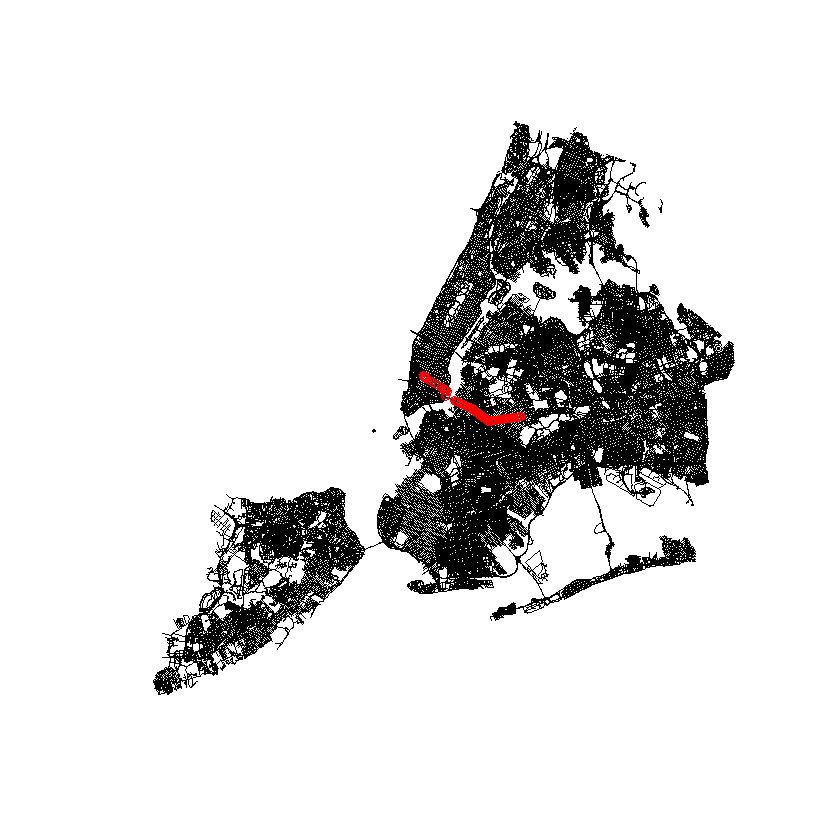

In [27]:
plot(shpNYC)
points(nodes[nodespath, ], col = "red")